# Assignment 1

Authors: 
- Andreas Rosenquist (s214604)
- Felix Lund Frandsen (s214584)
- Kasper Rønberg (s214786)


## Assignment 1.1: Exploring WS and BA models

In [112]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import numpy as np
import requests
import os
import re

# Set seaborn style
sns.set(style="darkgrid")

### Part 1:

#### Exercises: Did you really read the text? Answer the following questions (no calculations needed) in your IPython notebook.

- What's the problem with random networks as a model for real-world networks according to the argument in section 3.5 (near the end)?

In random networks no clear outliers are apparent.

- List the four regimes that characterize random networks as a function of ⟨k⟩

Subcritical where k < 1, Critical Point where k = 1, Supercritcal Regime where k > 1, and Connected Regime where k > lnN

- According to the book, why is it a problem for random networks (in terms of being a model for real-world networks) that the degree-dependent clustering C(k)
 decreases as a function of k
 in real-world networks?

 Due to random models not capturing the clustering coefficient, they become poor models for real networks.

#### Exercises: WS edition.

#### First, let's use networkx to play around with WS graphs. Use nx.watts_strogatz_graph to generate 3 graphs with 500 nodes each, average degree = 4, and rewiring probablity  p=0,0.1, and  1.Calculate the average shortest path length  ⟨d⟩ for each one.

In [113]:
N = 500
k = 4
p = [0, 0.1, 1]

WG0 = nx.watts_strogatz_graph(N, k, p[0])
WG1 = nx.watts_strogatz_graph(N, k, p[1])
WG2 = nx.watts_strogatz_graph(N, k, p[2])  

In [114]:
WG0_avg_path_length = nx.average_shortest_path_length(WG0)
WG1_avg_path_length = nx.average_shortest_path_length(WG1)
WG2_avg_path_length = nx.average_shortest_path_length(WG2)
print("Average path length for p=0: ", WG0_avg_path_length)
print("Average path length for p=0.1: ", WG1_avg_path_length)
print("Average path length for p=1: ", WG2_avg_path_length)

Average path length for p=0:  62.875751503006015
Average path length for p=0.1:  7.991158316633267
Average path length for p=1:  4.7687454909819635


#### Describe what happens to the network when  p=1.

Increasing the paramter p will increase the randomness of the network, i.e. reducing the clustering of the random network. A intermediate p will resemble the small world phenomenon of random networks, as the wiring of the edges will be more random and not only focus on the k-nearest neighbours. At p=1 we see that the average shortest path length increase significantly from p=0.1, this would indicate a futher reduction in the clustering. In other words, at p=1 for the Watt-Strogatz random network it will fully neglect the characteristc of wiring to close neighbours, but instead  choosing uniformly at random to wire an edge to any node in the network. This will naturally result in shorter paths as the network becomes more intertwined.

In [115]:
extracted_ds = {}

ps = [0, 0.01, 0.03, 0.05, 0.1, 0.2]
N = 500
k = 4

for i in range(50):
    for p in ps:
        WSG = nx.watts_strogatz_graph(N, k, p)
        avg_path_length = nx.average_shortest_path_length(WSG)
        if p not in extracted_ds:
            extracted_ds[p] = [avg_path_length] 
        else:
            extracted_ds[p].append(avg_path_length)


In [116]:
# code block brought to you by chatGPT
extracted_ds_avg = {p: sum(lengths)/len(lengths) for p, lengths in extracted_ds.items()}
extracted_ds_sd = {p: (sum((x - extracted_ds_avg[p]) ** 2 for x in lengths) / len(lengths))**0.5 for p, lengths in extracted_ds.items()}

In [117]:
ds_avg = list(extracted_ds_avg.values())
ds_sd = list(extracted_ds_sd.values())

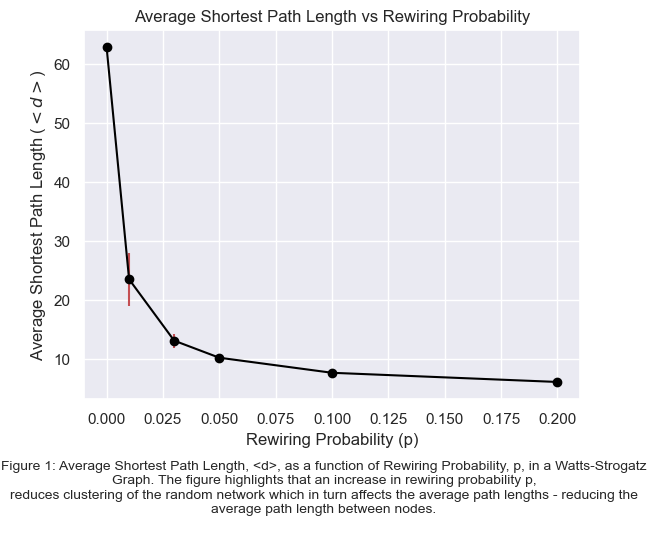

In [118]:
plt.errorbar(ps, ds_avg, yerr=ds_sd, fmt='o', ecolor='r', capthick=2, color='black')
plt.plot(ps, ds_avg, linestyle='-', color='black')
plt.xlabel('Rewiring Probability (p)')
plt.ylabel('Average Shortest Path Length ($<d>$)')
plt.title('Average Shortest Path Length vs Rewiring Probability')
figure_text = """
Figure 1: Average Shortest Path Length, <d>, as a function of Rewiring Probability, p, in a Watts-Strogatz Graph. The figure highlights that an increase in rewiring probability p,
reduces clustering of the random network which in turn affects the average path lengths - reducing the average path length between nodes.
"""
plt.figtext(0.5, -0.15, 
            figure_text,
            wrap=True, 
            horizontalalignment='center', 
            fontsize=10
            )
plt.show()

### Part 2:

In [119]:
# Initialize the BA graph with two connected nodes
BA = nx.Graph()
BA.add_node(1)
BA.add_node(2)
BA.add_edge(1, 2)

# Loop from 3 to 5000+1 to populate the graph with 5000 nodes
for i in range(3, 5000+1):
    # Add the new node
    BA.add_node(i)
    # We choose an existing node to connect to, with probability proportional to its degree (here we use itertools.chain to flatten the edge list)
    chosen_node = random.choice(list(itertools.chain.from_iterable(edge for edge in BA.edges)))
    # Add the edge between the new node and the chosen existing node
    BA.add_edge(i, chosen_node)


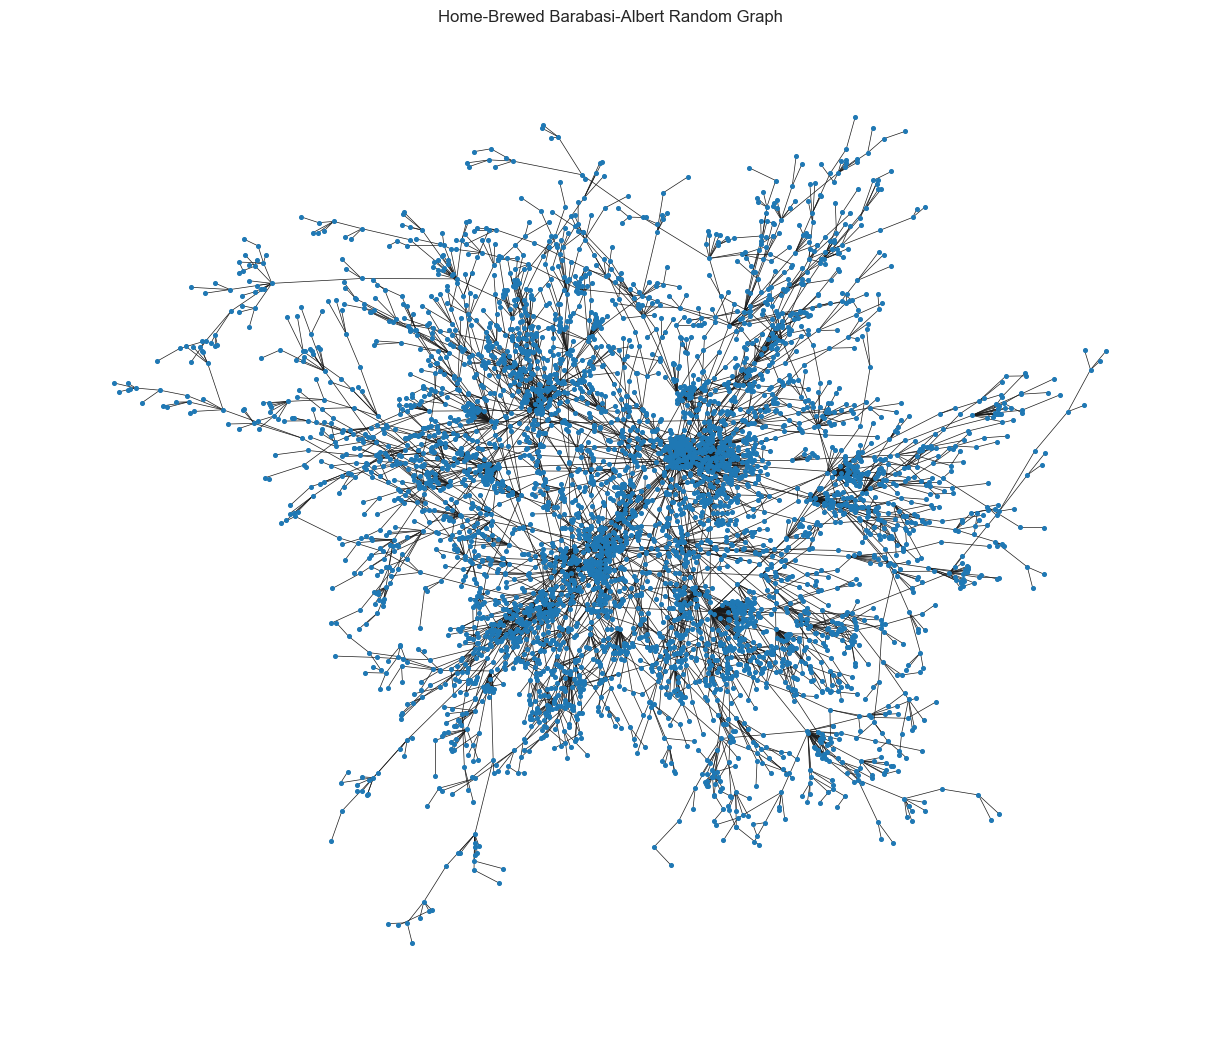

In [120]:
# Plot BA graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(BA, k=0.2, iterations=100, seed=420)
nx.draw(BA, pos=pos, node_size=7, width=0.5)
plt.title(label="Home-Brewed Barabasi-Albert Random Graph")
plt.show()

In [121]:
# Gather edges for each node
edges_count = {}
for i in range(1, 5001):
    edges_count[i] = len(BA.edges(i))

In [122]:
# code block brought to you by chatGPT
# Finds max and min degree nodes and their degrees
max_degree_node = max(edges_count, key=edges_count.get)
print("Node with highest degree:", max_degree_node)
print("Degree of that node:", edges_count[max_degree_node])

min_degree_node = min(edges_count, key=edges_count.get)
print("Node with lowest degree:", min_degree_node)
print("Degree of that node:", edges_count[min_degree_node])

Node with highest degree: 2
Degree of that node: 235
Node with lowest degree: 38
Degree of that node: 1


In [123]:
# Create bins and edges based on degree counts and bin ranges based on maximum degree
bins, edges = np.histogram(
                        list(edges_count.values()), 
                        bins=range(1,  edges_count[max_degree_node]+2)
                        )

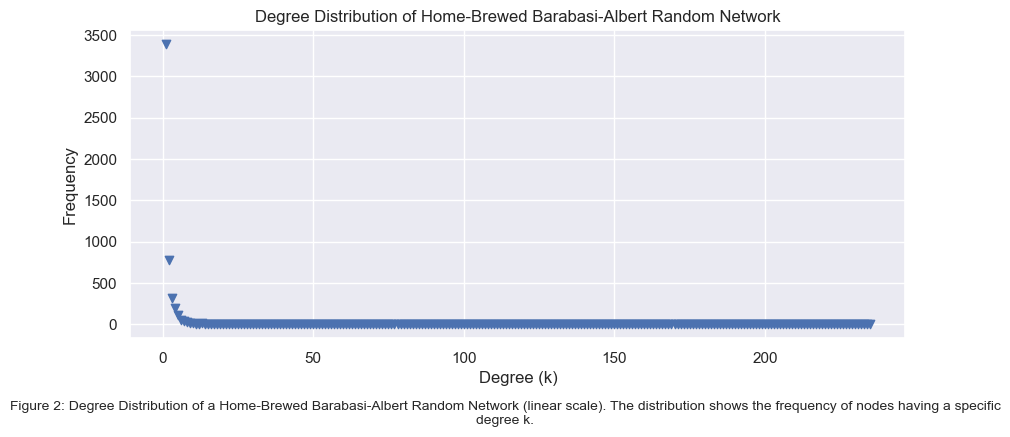

In [124]:
plt.figure(figsize=(10, 4))
plt.scatter(edges[:-1], bins, marker='v')
plt.ylabel('Frequency')
plt.xlabel('Degree (k)')
plt.title('Degree Distribution of Home-Brewed Barabasi-Albert Random Network')
plt.figtext(0.5, -0.10, 
            "Figure 2: Degree Distribution of a Home-Brewed Barabasi-Albert Random Network (linear scale). The distribution shows the frequency of nodes having a specific degree k.",
            wrap=True, 
            horizontalalignment='center', 
            fontsize=10
            )
plt.show()

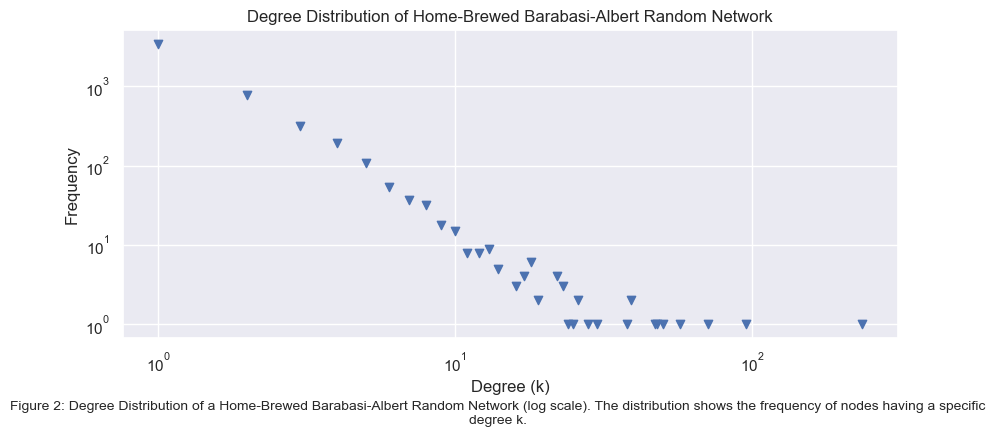

In [125]:
plt.figure(figsize=(10, 4))
plt.scatter(edges[:-1], bins, marker='v')
plt.ylabel('Frequency')
plt.xlabel('Degree (k)')
plt.title('Degree Distribution of Home-Brewed Barabasi-Albert Random Network')
plt.yscale('log')
plt.xscale('log')
plt.figtext(0.5, -0.10, 
            "Figure 2: Degree Distribution of a Home-Brewed Barabasi-Albert Random Network (log scale). The distribution shows the frequency of nodes having a specific degree k.",
            wrap=True, 
            horizontalalignment='center', 
            fontsize=10
            )
plt.show()

## Assignment 1.2 Stats and visualization of the Rock Music Network

### 1.2.1 Explain your process in words

#### First, simply describe the steps of the process (what you did, step by step).

First, we collected a list of rock bands and performers from a Wikipedia page. Using regular expressions, we extracted all the links from this page. The performer names were then isolated, and the corresponding pages were downloaded, stored as JSON files, and saved to a text file. Next, we initialized a directed graph using networkx. Each performer was added as a node, with their word count stored as a node attribute. We then scraped the performer text file for links, and if a link matched another performer in our dataset, we added it as a directed edge. Finally, we removed isolated nodes and extracted the largest weakly connected component. 

#### Then, write a short section about which part of the process that was most difficult.

The most challenging part was extracting the JSON files from the Wikipedia pages, as we encountered a 403 Bad Gateway error. Furthermore, many wiki-links were outdated and required redirecting, which caused us to extract empty wiki-pages. This caused several issues and required a debugging session. We ultimately resolved the problems by specifying a user agent and adding the redirect as a parameter.

#### Next write a short section about how you used LLMs to help you.

We used LLMs to help debug the code when we encountered problems and to review our code for potential errors that could lead to incorrect data extraction.

#### Finally, compose a short section about what you would do differently if you had to do it again

We would set up stronger filtering before downloading pages; making sure to drop categories and resolve redirects before fetching the wiki-pages. We would also implement error handling from the start to catch any empty wiki-pages by having a minimum characters filter and an error warning for fetching bad files. 

### 1.2.3 Simple network statistics and analysis

##### Download and load the network from github.

In [126]:
# download the graph as a gml file from github
url = "https://raw.githubusercontent.com/AIAndreas/SG-IAssignment1/main/data/rock_performers_graph.gml"
response = requests.get(url)

with open("rock_performers_graph.gml", "wb") as file:
    file.write(response.content)

# Load the graph from the gml file
G = nx.read_gml("rock_performers_graph.gml")

#### What is the number of nodes in the network?

In [127]:
print(f"The graph has {G.number_of_nodes()} nodes.")

The graph has 487 nodes.


#### More importantly, what is the number of links?

In [128]:
print(f"The graph has {G.number_of_edges()} edges.")

The graph has 7369 edges.


#### Plot the in and out-degree distributions for the entire network. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?

- Compare the out-degree distribution to a random network with the same number of nodes and links.

- Compare the in-degree distribution to a scale-free network with the same number of nodes.


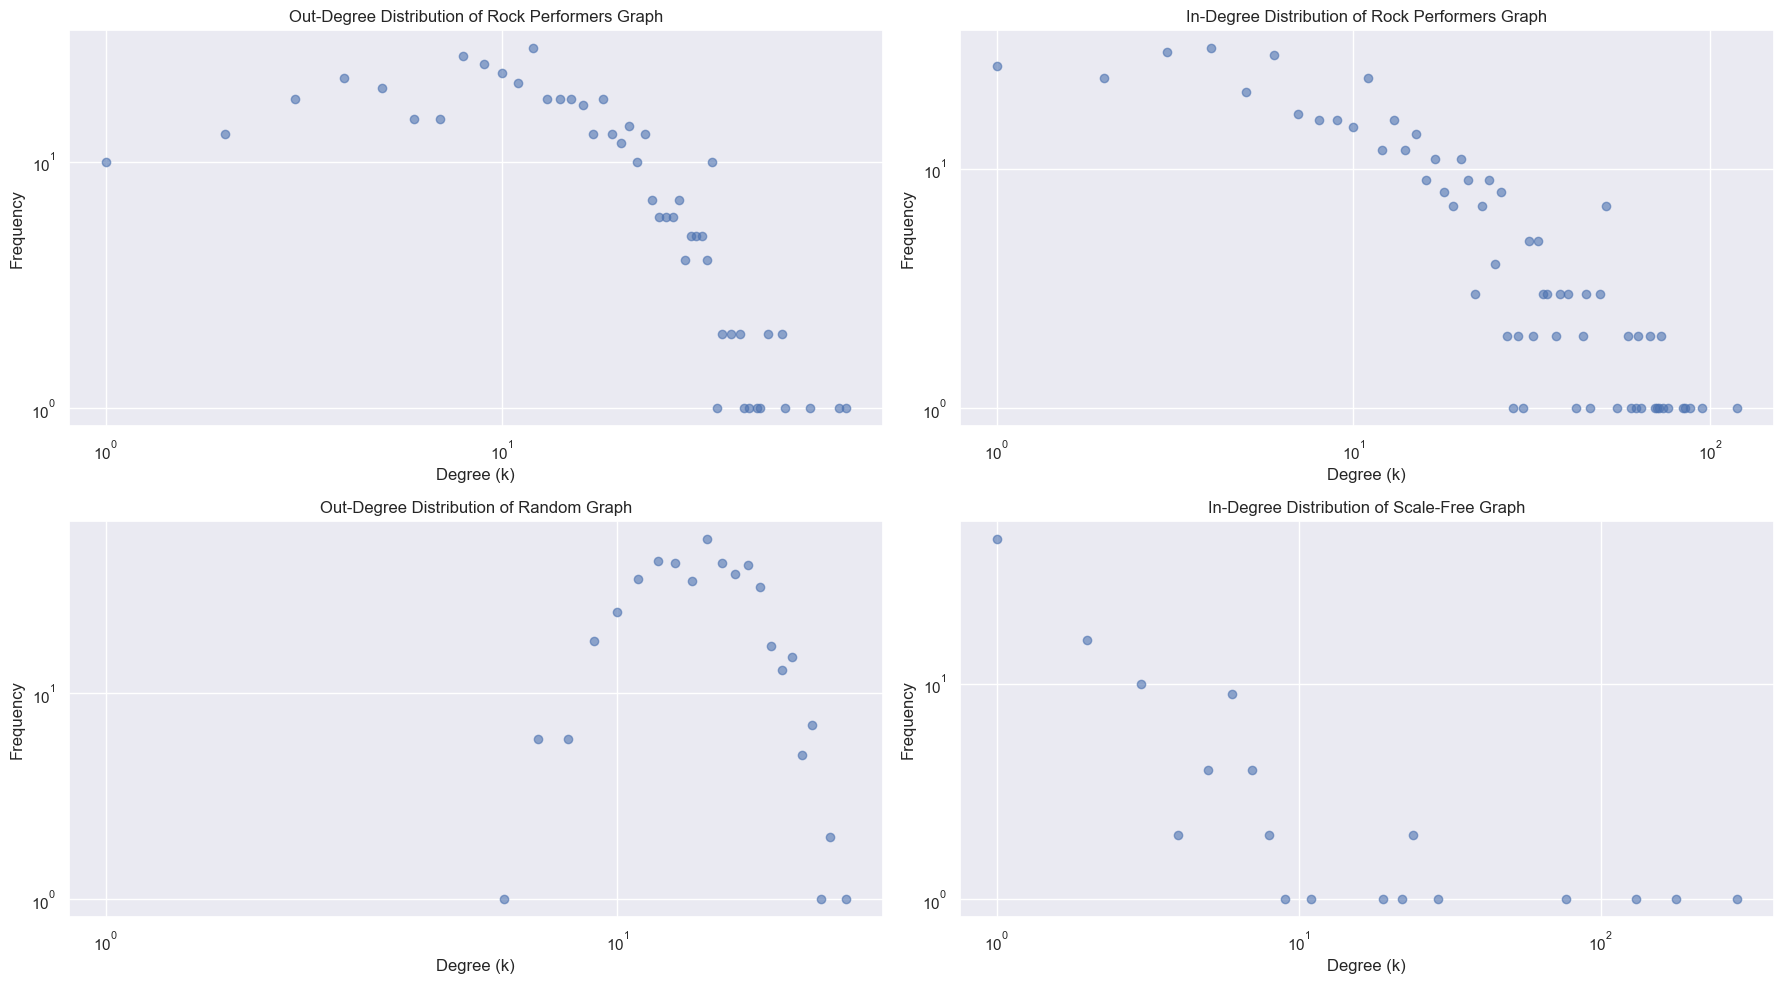

In [129]:
# Reference graphs for comparison
random_graph = nx.gnm_random_graph(
    G.number_of_nodes(), G.number_of_edges(), 
    directed=True
    )

scale_free_graph = nx.scale_free_graph(
    G.number_of_nodes()).to_directed()

in_degrees_G = [d for n, d in G.in_degree()]
out_degrees_G = [d for n, d in G.out_degree()]

out_degrees_random = [d for n, d in random_graph.out_degree()]
in_degrees_scale_free = [d for n, d in scale_free_graph.in_degree()]

def plot_degree_distribution(degrees, title, ax, xlabel='Degree (k)', ylabel='Frequency'):
    bins, edges = np.histogram(degrees, bins=range(1, max(degrees)+2))
    ax.scatter(edges[:-1], bins, marker='o', alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('log')
    ax.set_yscale('log')

fig, axs = plt.subplots(2, 2, figsize=(18, 10))
plot_degree_distribution(out_degrees_G, 'Out-Degree Distribution of Rock Performers Graph', axs[0, 0])
plot_degree_distribution(in_degrees_G, 'In-Degree Distribution of Rock Performers Graph', axs[0, 1])
plot_degree_distribution(out_degrees_random, 'Out-Degree Distribution of Random Graph', axs[1, 0])
plot_degree_distribution(in_degrees_scale_free, 'In-Degree Distribution of Scale-Free Graph', axs[1, 1])
plt.tight_layout()
plt.show()

The random network follows the expected Poisson distribution, with most nodes having degrees clustered around the mean and very few outliers. In contrast, the rock performers’ out-degree distribution is more dispersed and exhibits a heavier tail. This means that while most performers reference only a few others, some reference disproportionately many. 

The rock performers’ in-degree distribution shows a clear heavy-tailed pattern, even more pronounced than the scale-free network. This suggests a preferential attachment pattern (insert ref); performers who are already well-known or influential are disproportionately more likely to be referenced by new entrants, leading to the emergence of hubs.

#### Who are the top 5 most connected performers (Report results for in-degrees and out-degrees, that is, who has highest in-degree, who has highest out-degree)? Comment on your findings. Is this what you would have expected?

In [130]:
# find top 5 most connected performers by in-degree and out-degree
top_in_degree = sorted(G.in_degree(), key=lambda x: x[1], 
                       reverse=True)[:5]

top_out_degree = sorted(G.out_degree(), key=lambda x: x[1], 
                        reverse=True)[:5]

# Remove text in parentheses and underscores from performer names
def normalize_label(raw_name: str) -> str:
    label = raw_name.replace('_', ' ')
    label = re.sub(r'\s*\(.*?\)\s*', '', label)
    return label.strip()

top_in_degree = [(normalize_label(name), degree) for name, degree in top_in_degree]
top_out_degree = [(normalize_label(name), degree) for name, degree in top_out_degree]

print("Top 5 performers by in-degree:")
for i, (performer, degree) in enumerate(top_in_degree):
    print(f"{i+1}. {performer}, In-Degree: {degree}")

print("\nTop 5 performers by out-degree:")
for i, (performer, degree) in enumerate(top_out_degree):
    print(f"{i+1}. {performer}, Out-Degree: {degree}")


Top 5 performers by in-degree:
1. Led Zeppelin, In-Degree: 119
2. Bob Dylan, In-Degree: 95
3. Queen, In-Degree: 88
4. Metallica, In-Degree: 85
5. David Bowie, In-Degree: 84

Top 5 performers by out-degree:
1. Alice in Chains, Out-Degree: 74
2. Deep Purple, Out-Degree: 71
3. Black Sabbath, Out-Degree: 60
4. Def Leppard, Out-Degree: 52
5. Guns N' Roses, Out-Degree: 51


The performers with the highest in-degrees are well-known rock bands or artists with significant influence and recognition in the music industry. This makes sense because their Wikipedia pages are frequently referenced by other performers, likely due to their historical importance, collaborations, or influence on the genre. 

On the other hand, the performers with the highest out-degrees include some lesser-known artists. This observation is also logical, as a high out-degree suggests that these performers' Wikipedia pages link to many other performers. This could be due to their extensive collaborations, inspirations, or influences from a wide range of artists.

#### What are the 10 pages with the longest wiki entries? (use the length of content attribute to figure this one out)?

In [131]:
node_word_counts = [(n, d['word_count']) for n, d in G.nodes(data=True)]
top_10_longest = sorted(node_word_counts, key=lambda x: x[1], reverse=True)[:10]

print("Top 10 pages with the longest wiki entries:")
for i, (node, count) in enumerate(top_10_longest):
    print(f"{i+1}. {node}, Word Count: {count}")

Top 10 pages with the longest wiki entries:
1. Guns_N'_Roses, Word Count: 60853
2. Coldplay, Word Count: 47026
3. Queen_(band), Word Count: 46197
4. Marilyn_Manson_(band), Word Count: 46032
5. The_Rolling_Stones, Word Count: 44022
6. U2, Word Count: 43048
7. Bob_Dylan, Word Count: 42509
8. David_Bowie, Word Count: 42408
9. Paul_McCartney, Word Count: 42407
10. Elton_John, Word Count: 41255


## Assignment 3 Let's build a simple visualization of the network


#### For the sake of the visualisation, let's convert our network to undirected graph (tip: There is a NetworkX command to help you).



In [132]:
G_undir = G.copy().to_undirected()

#### Use the NetworkX command nx.spring_layout or nx.draw_kamada_kawai to draw the resulting undirected network.

* Set up your plot so that node-size depends on the node degree.

* Make the node color depend on the length of content attribute. I recommend choosing a color scheme that is quite simple

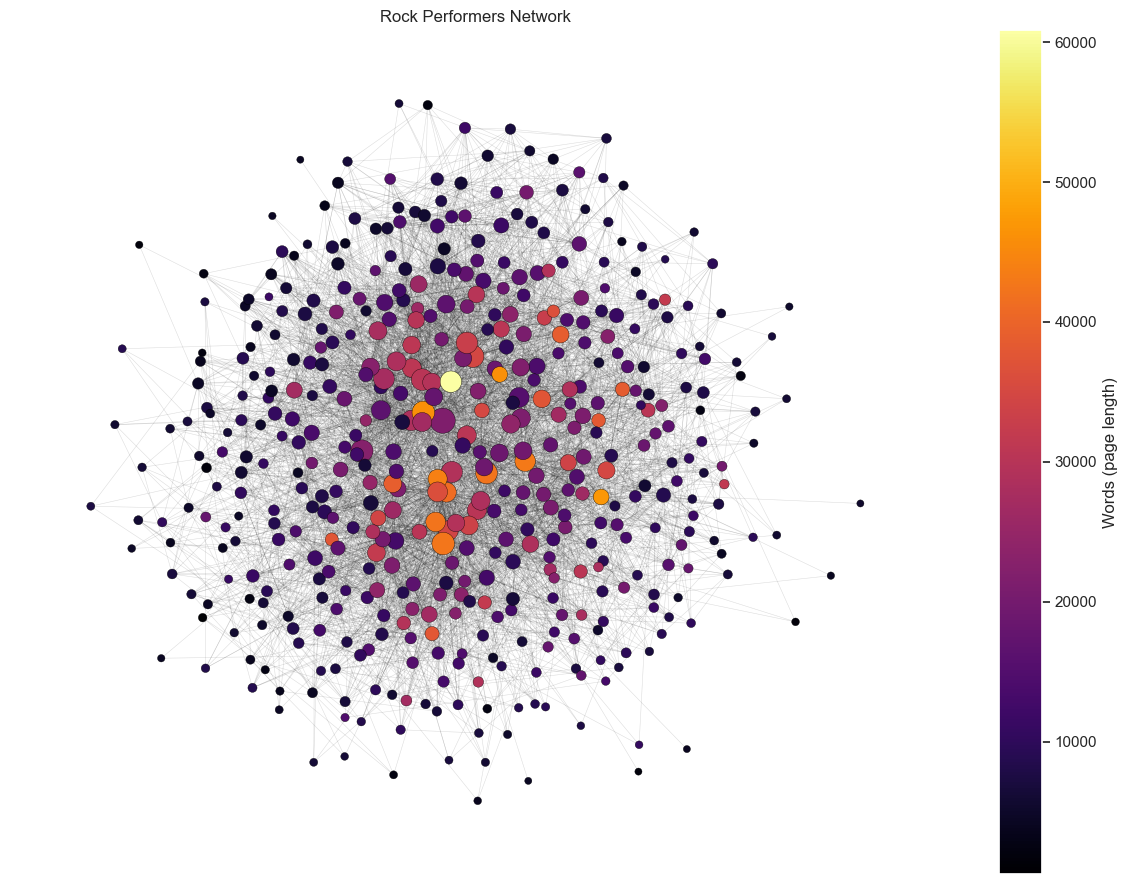

In [133]:
spring_pos = nx.spring_layout(G_undir, k=20, scale=20, seed=42)
kamada_pos = nx.kamada_kawai_layout(G_undir, pos=spring_pos, weight=None, scale=20)

deg = dict(G_undir.degree())
deg_vals = np.array([deg[n] for n in G_undir.nodes()])

# Get word counts directly from node attributes
words = [p['word_count'] for n, p in G_undir.nodes(data=True)]
sizes = (120 + 12 * deg_vals)*0.2 
cmap = plt.cm.inferno

plt.figure(figsize=(12, 9))
nx.draw_networkx_edges(G_undir, kamada_pos, alpha=0.15, width=0.4)
nodes = nx.draw_networkx_nodes(
    G_undir, kamada_pos,
    node_size=sizes,
    node_color=words,
    cmap=cmap,
    linewidths=0.25,
    edgecolors='black',
)

plt.title('Rock Performers Network')
colorbar = plt.colorbar(nodes)
colorbar.set_label('Words (page length)')
plt.axis('off')
plt.tight_layout()
plt.show()